In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
articles = pd.read_csv("../data/articles.csv")
cust = pd.read_csv("../data/customers.csv")
trans = pd.read_csv("../data/transactions_train.csv")

In [3]:
articles.shape

(105542, 25)

In [4]:
articles.head(10)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
5,110065011,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,12,Light Beige,1,Dusty Light,11,Beige,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
6,111565001,111565,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
7,111565003,111565,20 den 1p Stockings,302,Socks,Socks & Tights,1010016,Solid,13,Beige,2,Medium Dusty,11,Beige,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
8,111586001,111586,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Tights with built-in support to lift the botto...
9,111593001,111593,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny tights that shape the tummy, thighs..."


In [5]:
## Just a handle of description missing
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [6]:
print(cust.customer_id.nunique())
cust.info()

1371980
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [7]:
cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [8]:
trans.shape[0]

31788324

In [9]:
trans.head()
#590

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [10]:
# Getting only the online transactions

df_trans = trans[trans['sales_channel_id'] == 2].copy()
df_trans['year'] = trans.t_dat.apply(lambda date: date.split("-")[0]);
df_trans['month'] = trans.t_dat.apply(lambda date: date.split("-")[1]);


In [11]:
## To split the dataset according to this distribution. Unless we are looking into time series prediction. 
df_trans.year.value_counts(normalize=True)

2019    0.50927
2020    0.35764
2018    0.13309
Name: year, dtype: float64

In [12]:
df_trans[(df_trans['year'] == "2020")]['month'].value_counts(normalize=True)

04    0.167528
06    0.146698
05    0.121199
03    0.111653
08    0.103028
07    0.102002
01    0.094833
02    0.084608
09    0.068450
Name: month, dtype: float64

In [13]:
df_trans[(df_trans['year'] == "2019")]['month'].value_counts(normalize=True)

06    0.117593
07    0.107814
05    0.093830
04    0.090745
01    0.081836
03    0.081178
09    0.078278
11    0.076448
08    0.074590
10    0.069593
02    0.068115
12    0.059980
Name: month, dtype: float64

In [14]:
df_trans[(df_trans['year'] == "2018")]['month'].value_counts(normalize=True)

10    0.327024
11    0.305725
12    0.237171
09    0.130081
Name: month, dtype: float64

In [15]:
# df_train_trans = df_trans.groupby('year', group_keys=False).apply(lambda x: x.sample(frac=0.7))

In [16]:
# df_train_trans['year'].value_counts(normalize=True)

## Calculating customer lifetime value

Grouping customer with their transactions data

In [17]:
df_trans = df_trans.groupby(['t_dat','customer_id']).agg(price=('price', sum)).reset_index()

In [18]:
df = pd.merge(left= cust, right = df_trans,on ='customer_id', how="left")
df.shape

(5755269, 9)

In [19]:
df.head(1)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,t_dat,price
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,2019-05-02,0.010153


In [20]:
df['customer_id'].nunique()

1371980

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5755269 entries, 0 to 5755268
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   customer_id             object 
 1   FN                      float64
 2   Active                  float64
 3   club_member_status      object 
 4   fashion_news_frequency  object 
 5   age                     float64
 6   postal_code             object 
 7   t_dat                   object 
 8   price                   float64
dtypes: float64(4), object(5)
memory usage: 439.1+ MB


In [22]:
df['t_dat'] = pd.to_datetime(df['t_dat'])

In [23]:
df2 = df.groupby(['customer_id']).agg(recency=("t_dat", min), avg_price=("price",np.mean))

In [24]:
df['year'] = df['t_dat'].apply(lambda dat: dat.year)
df.groupby(['customer_id','year']).count().head()

FN  Active  \
customer_id                                        year                 
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2019.0   0       0   
                                                   2020.0   0       0   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0   0       0   
                                                   2019.0   0       0   
                                                   2020.0   0       0   

                                                           club_member_status  \
customer_id                                        year                         
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2019.0                   5   
                                                   2020.0                   1   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0                   3   
                                                   2019.0                  13   
                                                   2020.0                   4   

                                                           fashion_news_frequency  \
customer_id                                        year                             
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2019.0                       5   
                                                   2020.0                       1   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0                       3   
                                                   2019.0                      13   
                                                   2020.0                       4   

                                                           age  postal_code  \
customer_id                                        year                       
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2019.0    5            5   
                                                   2020.0    1            1   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0    3            3   
                                                   2019.0   13           13   
                                                   2020.0    4            4   

                                                           t_dat  price  
customer_id                                        year                  
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2019.0      5      5  
                                                   2020.0      1      1  
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0      3      3  
                                                   2019.0     13     13  
                                                   2020.0      4      4

In [25]:
df2['freq_per_year'] = df.groupby(['customer_id','year']).count().groupby(['customer_id'])['t_dat'].mean()

In [26]:
latest_trans = df['t_dat'].max()
df2['days_after_last_trans'] = df2['recency'].apply(lambda dat: (latest_trans- dat).days )
df2.head()


,recency,avg_price,freq_per_year,days_after_last_trans
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2019-05-02,0.062480,3.000000,509.0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2018-09-21,0.125525,6.666667,732.0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,2018-09-20,0.100683,2.333333,733.0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2019-06-09,0.060983,1.000000,471.0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,2019-03-07,0.080386,2.500000,565.0


Visualing the distribution

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price', ylabel='Density'>

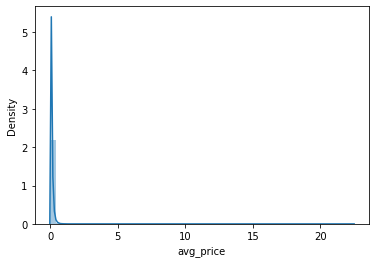

In [27]:
sns.distplot(df2['avg_price'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price', ylabel='Density'>

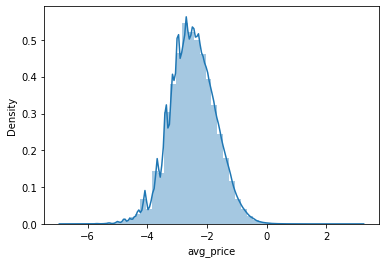

In [28]:
sns.distplot(np.log(df2['avg_price']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='freq_per_year', ylabel='Density'>

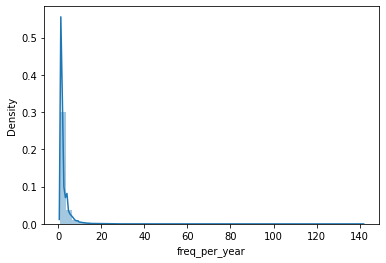

In [29]:
sns.distplot(df2['freq_per_year'])

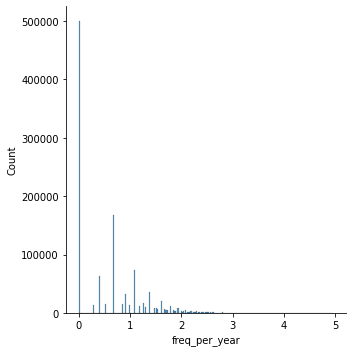

In [30]:
sns.displot(np.log(df2['freq_per_year']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_after_last_trans', ylabel='Density'>

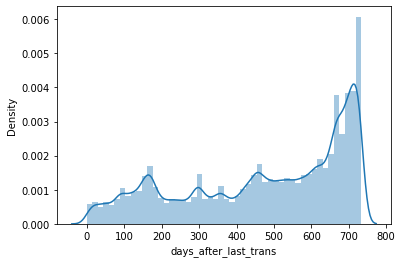

In [31]:
sns.distplot(df2['days_after_last_trans'])

In [32]:
df2 = df2.drop('recency',axis=1).dropna()

In [56]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

cost = []
df_norm = pd.DataFrame(normalize(df2), columns=df2.columns,index=df2.index)
k = range(1,8)

for num_cluster in k:
    kmeans = KMeans(n_clusters=num_cluster)
    kmeans.fit(df_norm)
    cost.append(kmeans.inertia_)

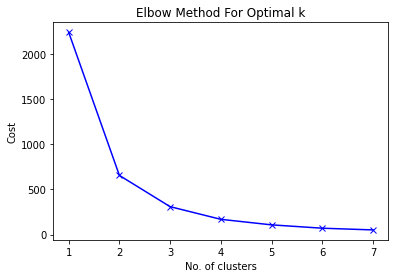

In [57]:
plt.plot(k,cost,'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title("Elbow Method For Optimal k")
plt.show()
# Optimal cluster to be at cluster 7

In [58]:
kmeans = KMeans(2)
kmeans.fit(df_norm)
df_norm['cluster'] = kmeans.predict(df_norm)

<AxesSubplot:xlabel='freq_per_year', ylabel='avg_price'>

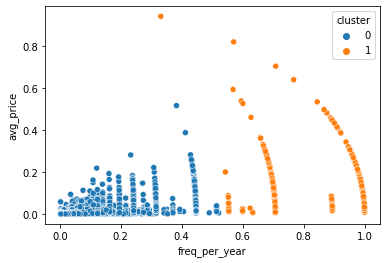

In [59]:
sns.scatterplot(data = df_norm[df_norm['avg_price'] <3], x= 'freq_per_year', y= 'avg_price', hue='cluster')

<AxesSubplot:xlabel='days_after_last_trans', ylabel='avg_price'>

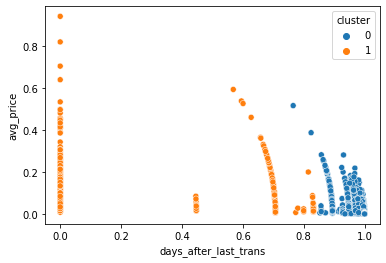

In [60]:
sns.scatterplot(data = df_norm, x= 'days_after_last_trans', y= 'avg_price', hue='cluster')

<AxesSubplot:xlabel='days_after_last_trans', ylabel='freq_per_year'>

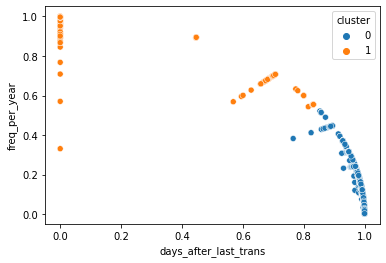

In [61]:
sns.scatterplot(data = df_norm, x= 'days_after_last_trans', y= 'freq_per_year', hue='cluster')

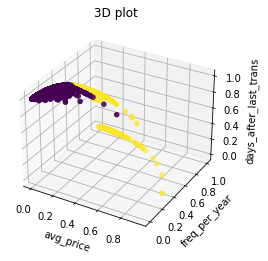

In [74]:
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

xs = df_norm['avg_price']
ys = df_norm['freq_per_year']
zs = df_norm['days_after_last_trans']
cluster = df_norm.cluster
  
# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, c=cluster)
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel("avg_price")
ax.set_ylabel("freq_per_year")
ax.set_zlabel("days_after_last_trans")
  
# displaying the plot
plt.show()



In [75]:
df_norm.head()

,avg_price,freq_per_year,days_after_last_trans,cluster
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.000123,0.005894,0.999983,0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0.000171,0.009107,0.999959,0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.000137,0.003183,0.999995,0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.000129,0.002123,0.999998,0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.000142,0.004425,0.999990,0


## Clustering with beyond the 3 variables

In [90]:
df_norm2 = pd.merge(left=df_norm.drop(['cluster'],axis=1), right=df.drop(['postal_code','t_dat','price','year'],axis=1), left_index=True, right_on='customer_id').set_index('customer_id')


In [97]:
df_norm2['FN'] = df_norm2['FN'].replace(np.nan, 0)
df_norm2['Active'] = df_norm2['Active'].replace(np.nan, 0)
df_norm2['club_member_status'] = df_norm2['club_member_status'].replace(np.nan, "NONE")
df_norm2['fashion_news_frequency'] = df_norm2['fashion_news_frequency'].replace(np.nan, "NONE")
df_norm2['fashion_news_frequency'] = df_norm2['fashion_news_frequency'].replace("None", "NONE")
df_norm2 = df_norm2.replace(np.nan, np.mean(df_norm2['age']))

#### Encoding the categorical variables

In [98]:
df_cat = pd.get_dummies(df_norm2[['FN',"Active","club_member_status",'fashion_news_frequency']])
df_both = pd.merge(left=df_cat,right=df_norm2[['avg_price','freq_per_year','days_after_last_trans','age']], left_index=True, right_index=True)
df_both['age'] = normalize(df_both[['age']])

In [101]:
cost = []
k = range(1,5)

for num_cluster in k:
    kmeans = KMeans(n_clusters=num_cluster)
    kmeans.fit(df_both)
    cost.append(kmeans.inertia_)

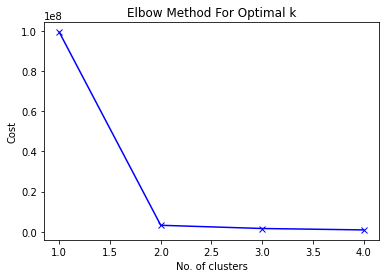

In [102]:
plt.plot(k,cost,'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title("Elbow Method For Optimal k")
plt.show()